In [136]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
!pip install adjustText
!pip install catboost
!pip install shap
!pip install eli5
!pip install scikit-optimize
!pip install bayesian-optimization
import pandas as pd
import re
import warnings
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import shap
import eli5
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV
from sklearn.metrics import r2_score
from eli5.sklearn import PermutationImportance  
from matplotlib.ticker import FuncFormatter
from adjustText import adjust_text
from textwrap import wrap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from catboost import Pool, cv, CatBoostClassifier
from sklearn.metrics import  classification_report, log_loss, roc_auc_score
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
games = pd.read_csv("/content/drive/MyDrive/L'algo de Paulo - mission 1 - datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/games.csv")
details = pd.read_csv("/content/drive/MyDrive/L'algo de Paulo - mission 1 - datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/games_details.csv")
teams = pd.read_csv("/content/drive/MyDrive/L'algo de Paulo - mission 1 - datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/teams.csv")
players = pd.read_csv("/content/drive/MyDrive/L'algo de Paulo - mission 1 - datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/players.csv")
ranking = pd.read_csv("/content/drive/MyDrive/L'algo de Paulo - mission 1 - datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/ranking.csv")
NEW=pd.read_csv("/content/drive/MyDrive/L'algo de Paulo - mission 1 - datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/ODD2019 (1).txt")

In [ ]:
# Compléments packages
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args
#https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/19_Hyper-Parameters.ipynb

In [138]:
games.head(1)

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2021-05-26,42000102,Final,1610612755,1610612764,2020,1610612755,120.0,0.557,0.684,0.429,26.0,45.0,1610612764,95.0,0.402,0.633,0.091,22.0,40.0,1


In [139]:
import pandas_profiling

In [140]:
#pfr = pandas_profiling.ProfileReport(games)

In [141]:
games['PTS_home'].dtype

dtype('float64')

In [142]:
# games['PTS_home']=games[['PTS_home']].dropna().astype(int)  ### inneficace

In [143]:
games = games.dropna(axis=0).astype({'PTS_home': np.int})
games = games.dropna(axis=0).astype({'PTS_away': np.int})

In [144]:
# creation nouvelle colonne 'result'
games['result']=games['PTS_home'].astype(str)+":"+games['PTS_away'].astype(str)

In [145]:
games.head(1)

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,result
0,2021-05-26,42000102,Final,1610612755,1610612764,2020,1610612755,120,0.557,0.684,0.429,26.0,45.0,1610612764,95,0.402,0.633,0.091,22.0,40.0,1,120:95


In [146]:
# avant reformatage
games.describe()

,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
count,2.457800e+04,2.457800e+04,2.457800e+04,24578.000000,2.457800e+04,24578.000000,24578.000000,24578.000000,24578.000000,24578.000000,24578.000000,2.457800e+04,24578.000000,24578.000000,24578.00000,24578.000000,24578.000000,24578.000000,24578.000000
mean,2.169025e+07,1.610613e+09,1.610613e+09,2011.416592,1.610613e+09,102.766621,0.460256,0.759083,0.356084,22.649972,43.272764,1.610613e+09,99.907641,0.449023,0.75738,0.349443,21.296607,41.972821,0.591423
std,5.456096e+06,8.643714e+00,8.658480e+00,5.128362,8.643714e+00,13.112642,0.056706,0.100530,0.113140,5.169164,6.609140,8.658480e+00,13.247136,0.055554,0.10330,0.111319,5.126141,6.508188,0.491581
min,1.030000e+07,1.610613e+09,1.610613e+09,2003.000000,1.610613e+09,36.000000,0.250000,0.143000,0.000000,6.000000,15.000000,1.610613e+09,33.000000,0.244000,0.14300,0.000000,4.000000,19.000000,0.000000
25%,2.060095e+07,1.610613e+09,1.610613e+09,2007.000000,1.610613e+09,94.000000,0.421000,0.696000,0.286000,19.000000,39.000000,1.610613e+09,91.000000,0.411000,0.69200,0.278000,18.000000,38.000000,0.000000
50%,2.110095e+07,1.610613e+09,1.610613e+09,2012.000000,1.610613e+09,102.000000,0.459000,0.765000,0.357000,22.000000,43.000000,1.610613e+09,99.000000,0.448000,0.76200,0.350000,21.000000,42.000000,1.000000
75%,2.160118e+07,1.610613e+09,1.610613e+09,2016.000000,1.610613e+09,111.000000,0.500000,0.828000,0.429000,26.000000,48.000000,1.610613e+09,109.000000,0.487000,0.82800,0.421000,25.000000,46.000000,1.000000
max,5.200021e+07,1.610613e+09,1.610613e+09,2020.000000,1.610613e+09,168.000000,0.684000,1.000000,1.000000,50.000000,72.000000,1.610613e+09,168.000000,0.674000,1.00000,1.000000,46.000000,81.000000,1.000000


In [147]:
# Reformatage Player NAME
details['PLAYER_NAME_SHORT'] = details['PLAYER_NAME'].str.replace('^(.).*\s(.*)', '\\1.\\2')   #     .* <=> followed by 0 or more (any) characters       ^<=> starts with 
# Reformatage Colonne  MIN
details[["MINS", "SECS"]] = details.MIN.str.extract(r"([^:]+):(.*)")
details.loc[(~details.MIN.str.contains(':', na = True)), 'SECS'] = details.MIN
details.MINS = pd.to_numeric(details.MINS)
details.SECS = pd.to_numeric(details.SECS)
details['PLAY_TIME'] = np.round(details.MINS.fillna(0) + details.SECS/60)

In [148]:
# DONNEES DE BASE DE LA TABLE 'INITIALE' GAME
games = games.loc[~games[['GAME_ID', 'GAME_DATE_EST']].duplicated()] #Leaving one entry per game
games['GAME_DATE_EST'] = pd.to_datetime(games.GAME_DATE_EST)

In [149]:
# TABLE RANKING
ranking['STANDINGSDATE'] = pd.to_datetime(ranking['STANDINGSDATE'])
ranking.sort_values('STANDINGSDATE', inplace = True)
ranking = ranking.loc[ranking.SEASON_ID // 10000 == 2]
ranking['SEASON_ID'] = ranking['SEASON_ID'] % 10000
ranking['MAX_S_GAMES'] = ranking.groupby('SEASON_ID').G.transform(max)
ranking.head(1)

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY,MAX_S_GAMES
164300,1610612752,0,2002,2003-10-01,East,New York,82,37,45,0.451,24-17,13-28,NaN,82


In [150]:
## A PARTIR DE LA TABLE RANKING
# Création d'un df avec début et fin de saison pour exclure les matchs de pré-saison et éliminatoires
start_dates = ranking.loc[ranking.SEASON_ID > 2002].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('FIRST_GAME').reset_index()     #ranking.SEASON_ID > 2002     ######
t = ranking.loc[(ranking['G'] == ranking['MAX_S_GAMES'])].groupby(['SEASON_ID', 'STANDINGSDATE'])['TEAM_ID'].nunique().to_frame('TEAMS').reset_index()


In [151]:
playoff_dates = t.loc[(t.TEAMS == 30) | ((t.TEAMS == 28) & (t.SEASON_ID == 2012)) | ((t.TEAMS == 29) & (t.SEASON_ID == 2003))].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('LAST_GAME').reset_index()
#playoff_dates = t.loc[(t.TEAMS == 30)].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('LAST_GAME').reset_index()                                                  ######
dates = start_dates.merge(playoff_dates, how = 'left')
dates.loc[dates.SEASON_ID == 2019, 'LAST_GAME'] = pd.to_datetime('2020-03-12') #Manually adding the end of regular season  #!!!!!


In [152]:
# TABLE DETAILS - selection des données de la saison régulière
# FUSION 1 
details = details.merge(games[['GAME_ID', 'GAME_DATE_EST', 'SEASON']], how = 'left')
# FUSION 2
details = details.merge(dates, left_on = 'SEASON', right_on = 'SEASON_ID', how = 'left')
details = details.loc[(details.LAST_GAME.isnull()) | ((details.GAME_DATE_EST <= details.LAST_GAME) & (details.GAME_DATE_EST > details.FIRST_GAME))]
#details = details.loc[(details.GAME_DATE_EST <= details.LAST_GAME) & (details.GAME_DATE_EST > details.FIRST_GAME)]

In [153]:
# TABLE GAMES (DONNEES DE BASE DE LA TABLE INITIALE)
# FUSION 1
games = games.merge(dates, left_on = 'SEASON', right_on = 'SEASON_ID', how = 'inner')
# selection des données de la saison régulière 
games = games.loc[games.LAST_GAME.isnull() | ((games.GAME_DATE_EST <= games.LAST_GAME) & (games.GAME_DATE_EST > games.FIRST_GAME))]
games.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME'], inplace=True)


In [154]:
## A PARTIR DE LA TABLE RANKING -> Création d'un nouveau df RANKING_SHORT avec la saison régulière uniquement et des valeurs pouvant être utilisées pour la modélisation
ranking_short = ranking[['TEAM_ID', 'SEASON_ID', 'STANDINGSDATE', 'CONFERENCE', 'TEAM', 'G', 'W', 'L', 'HOME_RECORD', 'ROAD_RECORD']].merge(dates)
ranking_short = ranking_short.loc[(ranking_short.STANDINGSDATE >= ranking_short.FIRST_GAME) & (ranking_short.STANDINGSDATE <= ranking_short.LAST_GAME)]
ranking_short = ranking_short.loc[ranking_short.G > 0]

In [155]:
### encodage manuel ONE HOT
ranking_short[['HOME_W', 'HOME_L']] = ranking_short.HOME_RECORD.str.split('-', expand = True)
ranking_short[['AWAY_W', 'AWAY_L']] = ranking_short.ROAD_RECORD.str.split('-', expand = True)
ranking_short[['HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']] = ranking_short[['HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']].apply(pd.to_numeric) 
ranking_short.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME', 'HOME_RECORD', 'ROAD_RECORD'], inplace = True)
ranking_short.sort_values('STANDINGSDATE', inplace = True)

In [156]:
## A PARTIR DE LA TABLE GAMES -> Création d'un nouveau df GAMES_SHORT avec la saison régulière uniquement et des valeurs pouvant être utilisées pour la modélisation
games_short = pd.merge(games[['GAME_ID', 'GAME_DATE_EST', 'SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'HOME_TEAM_WINS','result']], dates, left_on = 'SEASON', right_on = 'SEASON_ID')
games_short = games_short.loc[(games_short.GAME_DATE_EST > games_short.FIRST_GAME) & (games_short.GAME_DATE_EST <= games_short.LAST_GAME)]
games_short.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME'], inplace = True)
games_short.sort_values('GAME_DATE_EST', inplace = True)

In [157]:
def mov_mult(mov, elo_diff):
    return (mov + 3)**0.8/(7.5 + 0.006*(elo_diff))

def win_prob(elo_diff):
    return 1/(10**(-elo_diff/400) + 1)

def update_elo(team_elo, game_data, k=20):
    if game_data.MOV < 0:        
        mult = mov_mult(-game_data.MOV, -game_data.ELO_DIFF)
        elo_change =  k*(game_data.HOME_WIN_PR)*mult
        team_elo.loc[team_elo.TEAM == game_data.HOME_TEAM_ID, 'ELO'] -= elo_change
        team_elo.loc[team_elo.TEAM == game_data.VISITOR_TEAM_ID, 'ELO'] += elo_change
    else:
        mult = mov_mult(game_data.MOV, game_data.ELO_DIFF)
        elo_change =  k*(1-game_data.HOME_WIN_PR)*mult
        team_elo.loc[team_elo.TEAM == game_data.HOME_TEAM_ID, 'ELO'] += elo_change
        team_elo.loc[team_elo.TEAM == game_data.VISITOR_TEAM_ID, 'ELO'] -= elo_change    


In [214]:
elo_data = games[['GAME_DATE_EST', 'GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'PTS_home', 'PTS_away']].copy()
elo_data['MOV'] = elo_data['PTS_home'] - elo_data['PTS_away']
elo_data.sort_values('GAME_DATE_EST', inplace=True)
elo_data = elo_data.dropna()

# INITIALISATION DE NOUVELLES COLONNES DANS LA TABLE elo_data
elo_data[['HOME_ELO', 'VISITOR_ELO', 'ELO_DIFF', 'HOME_WIN_PR', 'VISITOR_WIN_PR']] = 0
elo_data.reset_index(inplace=True, drop=True)

In [159]:
teams_dict = dict(zip(teams.TEAM_ID, teams.ABBREVIATION))
team_elo = pd.DataFrame({'TEAM':pd.unique(elo_data[['HOME_TEAM_ID', 'VISITOR_TEAM_ID']].values.ravel('K')),'ELO':1500})
team_elo['NAME'] = team_elo.TEAM.map(teams_dict)
team_elo_l = []
## Pour obtenir l'indice de la colonne à partir de son nom, une solution est d'utiliser get_loc (),
current_season = 2020
home_elo_col = elo_data.columns.get_loc("HOME_ELO")
visitor_elo_col = elo_data.columns.get_loc("VISITOR_ELO")
home_team_col = elo_data.columns.get_loc('HOME_TEAM_ID')
visitor_team_col = elo_data.columns.get_loc('VISITOR_TEAM_ID')
elo_diff_col = elo_data.columns.get_loc('ELO_DIFF')
home_win_col = elo_data.columns.get_loc('HOME_WIN_PR')
visitor_win_col = elo_data.columns.get_loc('VISITOR_WIN_PR')

In [161]:
for i in range(len(elo_data)):
    if elo_data.iloc[i, elo_data.columns.get_loc('SEASON')] != current_season:
        team_elo_l.append(team_elo.sort_values(by = 'ELO', ascending = False).head(10).assign(SEASON = current_season))
        team_elo['ELO'] = 0.75*team_elo.ELO + 0.25*1500 # Reverting back to the mean for the start of each season
        current_season = elo_data.iloc[i, elo_data.columns.get_loc('SEASON')]
        
    elo_data.iloc[i, home_elo_col] = team_elo.loc[team_elo.TEAM == elo_data.iloc[i, home_team_col], 'ELO'].values + 100

    elo_data.iloc[i, visitor_elo_col] = team_elo.loc[team_elo.TEAM == elo_data.iloc[i, visitor_team_col], 'ELO'].values

    elo_data.iloc[i, elo_diff_col] = elo_data.iloc[i, home_elo_col] - elo_data.iloc[i, visitor_elo_col]

    elo_data.iloc[i, home_win_col] = win_prob(elo_data.iloc[i, elo_diff_col])

    elo_data.iloc[i, visitor_win_col] = 1-elo_data.iloc[i, home_win_col]
    
    update_elo(team_elo, elo_data.iloc[i])

team_elo_l.append(team_elo.sort_values(by = 'ELO', ascending = False).head(5).assign(SEASON = current_season)) #current_season

In [162]:
sorted_team_elo = team_elo.sort_values(ascending=False,by='ELO')


In [163]:
sn.set_theme(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))
sn.set_color_codes("pastel")
sn.set_color_codes("pastel")
sn.barplot(x="ELO", y="NAME", data=sorted_team_elo,
            label="ELO", color="darkblue")
ax.set(xlim=(1200, 1700));

In [164]:
# https://en.wikipedia.org/wiki/Player_efficiency_rating

In [165]:
details['FGMISSES'] = details.FGA - details.FGM
details['FTMISSES'] = details.FTA - details.FTM
details['EFF'] = details.PTS + details.REB + details.AST + details.STL + details.BLK - (details.TO + details.FGMISSES + details.FTMISSES)

# Creating the efficiency dataset
eff = details[['PLAYER_NAME', 'PLAYER_ID', 'SEASON', 'EFF']].copy()
eff.dropna(inplace=True)
eff = eff.groupby(['PLAYER_NAME', 'PLAYER_ID', 'SEASON'], as_index=False).sum()
eff.sort_values('EFF', ascending=False, inplace=True)
top_players = eff.groupby('SEASON', as_index=False).head(300).copy()  ####
top_players['NEXT_SEASON'] = top_players.SEASON + 1
eff['NEXT_SEASON'] = eff.SEASON + 1

# Efficiency per game per team
per_game_eff = details.loc[details.COMMENT.isnull()][['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'SEASON']].merge(eff, left_on=['PLAYER_ID', 'SEASON'], right_on=['PLAYER_ID', 'NEXT_SEASON'], how='left')
pge = per_game_eff.groupby(['GAME_ID', 'TEAM_ID'], as_index=False).EFF.mean()
pge.dropna(inplace= True)

# Top players based on efficiecy for the 2019 season
top_players.loc[top_players.SEASON == 2019, ['PLAYER_NAME', 'EFF']].T

,2971,3564,6307,5181,3149,2328,493,5318,7163,664,1692,8038,318,2226,2021,860,7180,4278,1418,4613,701,6328,3865,4502,4056,7935,899,2356,8553,6123,7394,4864,4143,4802,3701,1089,6467,7561,5069,4475,5021,4182,4954,7670,2262,1060,4602,6954,3361,2108,1522,7716,102,6083,7802,8133,8448,4665,6207,810,22,1784,433,3513,1992,2676,1461,1496,2766,4679,5240,6966,3855,5281,3130,7364,3032,2077,1974,5406,1609,5137,5628,1772,3301,7942,6367,160,4100,3688,2845,6053,6157,4093,1510,6556,5653,2187,5556,2470,7902,4687,2439,5813,2702,1968,1023,887,6446,2170,2391,5948,4310,3426,3017,5564,6448,6927,2193,8137,3002,2083,2070,3291,3936,7792,2296,1837,4785,7752,2363,3388,7830,5151,3916,8410,4401,791,7129,1032,6237,1192,1225,7155,2665,7380,1500,1976,803,8470,2614,6347,3344,3040,7709,1831,1711,3456,4533,2418,8121,6572,7851,6117,6681,4434,8272,2919,5119,4659,7392,6490,3955,5716,7165,6525,4448,2175,185,4730,8095,3847,2404,4982,4738,4935,746,7734,2885,5006,6088,7770,2871,1565,1052,1137,2477,606,1810,1979,35,7076,1622,3375,2745,4288,1120,696,5049,1841,2851,3459,5971,8195,5802,3397,8011,6475,3703,5638,5431,1683,5438,1347,851,5486,640,5856,4824,6724,8437,6129,451,6386,7693,3552,5910,2830,6033,3212,5338,3248,8602,7980,5708,5880,1124,5112,6294,4347,174,2822,7537,651,3278,4789,2506,4976,2273,7864,3133,2905,4193,4352,2656,1041,7002,1502,2002,4489,5721,8023,3576,5003,7518,4537,3053,2927,3899,1839,7197,1752,5600,2690,7397,4342,5233,1309,773,4855,1732,6186,4037,4620,8416,51,8337,7622,6879,7433
PLAYER_NAME,Giannis Antetokounmpo,James Harden,Nikola Jokic,LeBron James,Hassan Whiteside,Domantas Sabonis,Anthony Davis,Luka Doncic,Rudy Gobert,Bam Adebayo,Damian Lillard,Trae Young,Andre Drummond,Devin Booker,DeMar DeRozan,Bradley Beal,Russell Westbrook,Jonas Valanciunas,Chris Paul,Kawhi Leonard,Ben Simmons,Nikola Vucevic,Jayson Tatum,Julius Randle,Jimmy Butler,Tobias Harris,Brandon Ingram,Donovan Mitchell,Zach LaVine,Montrezl Harrell,Shai Gilgeous-Alexander,Khris Middleton,Joel Embiid,Kevin Love,Jarrett Allen,CJ McCollum,Pascal Siakam,Spencer Dinwiddie,LaMarcus Aldridge,Jrue Holiday,Kyle Lowry,John Collins,Kristaps Porzingis,Steven Adams,Devonte' Graham,Buddy Hield,Karl-Anthony Towns,Ricky Rubio,Ja Morant,Dennis Schroder,Collin Sexton,T.J. Warren,Al Horford,Mitchell Robinson,Terry Rozier,Tristan Thompson,Will Barton,Kelly Oubre Jr.,Nemanja Bjelica,Bojan Bogdanovic,Aaron Gordon,Danilo Gallinari,Andrew Wiggins,Jamal Murray,DeAndre Jordan,Eric Bledsoe,Christian Wood,Clint Capela,Evan Fournier,Kemba Walker,Lonzo Ball,Robert Covington,Jaylen Brown,Lou Williams,Harrison Barnes,Serge Ibaka,Gordon Hayward,Dejounte Murray,De'Aaron Fox,Malcolm Brogdon,D'Angelo Russell,Larry Nance Jr.,Markelle Fultz,Daniel Theis,Ivica Zubac,Tomas Satoransky,OG Anunoby,Alec Burks,Joe Ingles,Jaren Jackson Jr.,Fred VanVleet,Miles Bridges,Myles Turner,Joe Harris,Cody Zeller,Paul George,Marquese Chriss,Derrick Rose,Marcus Morris Sr.,Dwight Howard,Tim Hardaway Jr.,Kendrick Nunn,Duncan Robinson,Maxi Kleber,Eric Paschall,Davis Bertans,Brook Lopez,Brandon Clarke,P.J. Tucker,Derrick Favors,Dorian Finney-Smith,Mikal Bridges,Jordan Clarkson,Jae Crowder,Goran Dragic,Marcus Smart,P.J. Washington,Richaun Holmes,Derrick White,Troy Brown Jr.,Glenn Robinson III,Delon Wright,Deandre Ayton,Ish Smith,Jerami Grant,Terrence Ross,Dillon Brooks,Dario Saric,Kevin Huerter,Taurean Prince,Donte DiVincenzo,JaVale McGee,Thaddeus Young,Lauri Markkanen,Jeff Teague,Wendell Carter Jr.,Josh Hart,Bobby Portis,Royce O'Neale,Bruce Brown,Nerlens Noel,Carmelo Anthony,Cedi Osman,Rudy Gay,Enes Kanter,Seth Curry,Coby White,De'Andre Hunter,Bogdan Bogdanovic,Willie Cauley-Stein,Elfrid Payton,Norman Powell,JJ Redick,Gorgui Dieng,T.J. McConnell,Danuel House Jr.,Damion Lee,Jakob Poeltl,Justin Holiday,Draymond Green,Trey Lyles,Paul Millsap,Thomas Bryant,Monte Morris,RJ Barrett,Josh Okogie,Tyus Jones,George Hill,Langston Galloway,Kelly Olynyk,Shabazz Napier,Patrick Beverley,Jeremy Lamb,Mason Plumlee,Rui Hachimura,Patty Mills,Josh Richardson,Derrick Jones Jr.

In [166]:
# Top players based on efficiecy for the De season
top_players.loc[top_players.SEASON == 2020, ['PLAYER_NAME', 'EFF']].T

,6308,2972,4503,6329,7181,5319,7595,1693,2329,7164,3866,8603,665,1419,4279,1497,8039,4144,861,2071,2227,4865,8554,2022,4614,4603,4057,5050,2666,3565,900,2078,7936,7803,1975,5911,3856,4183,6928,3702,6468,5182,702,4660,434,4476,4983,6557,5407,2419,6682,5949,3362,7831,2357,1523,495,1061,3457,6124,3131,6348,7710,5717,1348,3302,4769,2846,6054,1501,3937,6449,4101,4311,811,792,3428,4646,1090,1024,6967,4094,3514,7903,319,5022,3460,4955,5071,2109,7130,5241,2084,1462,5972,5007,6955,1138,8229,6187,3267,3033,2297,2364,4786,1773,2471,2440,7671,8411,1842,2405,2677,6989,7233,888,1033,4666,8196,7395,6238,494,1993,6288,3900,6158,4534,1193,6514,2263,2392,1811,7166,4688,4856,4680,6880,7003,2171,804,7156,2188,4402,6368,8449,5565,4722,6857,4419,5557,3427,7398,1840,23,1610,5152,6476,3696,4449,3266,8134,4564,2205,7381,1511,1785,6573,4739,2767,4235,2906,5693,1131,1566,2446,7943,3122,3018,161,5432,5282,7769,6811,8273,3848,7737,6143,6526,2615,1520,7365,747,3241,3251,8492,186,1125,1969,7835,8515,1753,7793,4731,4842,8313,761,1226,3376,4485,6118,2785,2478,3057,5303,4752,1980,5814,3418,1053,5339,5234,6597,7623,2176,5138,2194,6089,4353,7735,2068,7981,175,2032,5113,103,338,2422,2872,7694,5487,7771,5639,6084,8471,2928,3577,2100,1712,1481,3389,8230,452,6274,3620,1623,1838,607,3292,2117,5722,6453,2823,2852,3553,8024,2257,7538,3956,2003,4490,4343,3150,3917,5439,7753,3467,852,36,4435,4803,6680,4825,6725,8403,3261,7232,6623,3054,2587,5399,7581,3041,8166,1977,5070,6130,6292,6405,6447,164
PLAYER_NAME,Nikola Jokic,Giannis Antetokounmpo,Julius Randle,Nikola Vucevic,Russell Westbrook,Luka Doncic,Stephen Curry,Damian Lillard,Domantas Sabonis,Rudy Gobert,Jayson Tatum,Zion Williamson,Bam Adebayo,Chris Paul,Jonas Valanciunas,Clint Capela,Trae Young,Joel Embiid,Bradley Beal,Deandre Ayton,Devin Booker,Khris Middleton,Zach LaVine,DeMar DeRozan,Kawhi Leonard,Karl-Anthony Towns,Jimmy Butler,Kyrie Irving,Enes Kanter,James Harden,Brandon Ingram,Dejounte Murray,Tobias Harris,Terry Rozier,De'Aaron Fox,Michael Porter Jr.,Jaylen Brown,John Collins,Richaun Holmes,Jarrett Allen,Pascal Siakam,LeBron James,Ben Simmons,Kelly Olynyk,Andrew Wiggins,Jrue Holiday,Kyle Anderson,Paul George,Malcolm Brogdon,Draymond Green,RJ Barrett,Mikal Bridges,Ja Morant,Thaddeus Young,Donovan Mitchell,Collin Sexton,Anthony Edwards,Buddy Hield,Jakob Poeltl,Montrezl Harrell,Harrison Barnes,Norman Powell,T.J. McConnell,Mason Plumlee,Chris Boucher,Ivica Zubac,Kevin Durant,Fred VanVleet,Miles Bridges,Coby White,Jerami Grant,P.J. Washington,Joe Ingles,Jordan Clarkson,Bojan Bogdanovic,Bobby Portis,Jae'Sean Tate,Keldon Johnson,CJ McCollum,Brook Lopez,Robert Covington,Joe Harris,Jamal Murray,Tim Hardaway Jr.,Andre Drummond,Kyle Lowry,Jalen Brunson,Kristaps Porzingis,LaMelo Ball,Dennis Schroder,Royce O'Neale,Lonzo Ball,Delon Wright,Christian Wood,Mike Conley,Kyle Kuzma,Ricky Rubio,Caris LeVert,Tyrese Haliburton,Naz Reid,Isaiah Stewart,Gordon Hayward,Dillon Brooks,Donte DiVincenzo,Kevin Huerter,Daniel Theis,Dwight Howard,Duncan Robinson,Steven Adams,Wendell Carter Jr.,Darius Garland,Doug McDermott,Eric Bledsoe,Robert Williams III,Saddiq Bey,Brandon Clarke,Bruce Brown,Kelly Oubre Jr.,Tyler Herro,Shai Gilgeous-Alexander,Nerlens Noel,Anthony Davis,DeAndre Jordan,Nicolas Batum,Jeff Green,Myles Turner,Justin Holiday,Carmelo Anthony,Patrick Williams,Devonte' Graham,Dorian Finney-Smith,Danny Green,Rui Hachimura,Kendrick Nunn,Khem Birch,Kemba Walker,Reggie Jackson,Robin Lopez,Derrick Favors,Bogdan Bogdanovic,Rudy Gay,Derrick Rose,Josh Hart,OG Anunoby,Will Barton,Marcus Smart,Kenrich Williams,Reggie Bullock,Josh Jackson,Marcus Morris Sr.,Jae Crowder,Shake Milton,Darius Bazley,Aaron Gordon,D'Angelo Russell,Lauri Markkanen,Pat Connaughton,Jarred Vanderbilt,Josh Richardson,Isaiah Roby,Tristan Thompson,Jusuf Nurkic,Desmond Bane,Seth Curry,Cody Zeller,Danilo Gallinari,Paul Millsap,Kentavious Caldwell-Pope,Evan Fournier,John Wall,Gary Trent Jr.,Marvin Bagley III,Cameron Payne,Cory Joseph,Dwayne Bacon,Tomas Satoransky,Hamidou Diallo,Go

In [167]:
plt.figure(figsize=(8,160))
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 2}
plt.rc('font', **font)
sn.set_theme(style="whitegrid")
sn.set_color_codes("pastel")
sn.set_color_codes("pastel")
sn.barplot(x="EFF", y="PLAYER_NAME", data=top_players,
            label="ELO", color="darkblue");
#ax.set(xlim=(1200, 2000));

In [168]:
top_players_per_game = details.loc[details.COMMENT.isnull()][['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'SEASON']].merge(top_players, left_on=['PLAYER_ID', 'SEASON'], right_on=['PLAYER_ID', 'NEXT_SEASON'], how='left')
top_players_per_game = top_players_per_game.groupby(['GAME_ID', 'TEAM_ID', 'SEASON_x']).PLAYER_NAME.agg(lambda x: x.notnull().sum()).reset_index()
top_players_per_game.columns = ['GAME_ID', 'TEAM_ID', 'SEASON', 'TOP_PLAYERS']
#top_players_per_game.drop(columns='SEASON', inplace=True)

In [169]:
# CHECK
top_players_per_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42792 entries, 0 to 42791
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   GAME_ID      42792 non-null  int64
 1   TEAM_ID      42792 non-null  int64
 2   SEASON       42792 non-null  int64
 3   TOP_PLAYERS  42792 non-null  int64
dtypes: int64(4)
memory usage: 1.3 MB


In [170]:
games_played = pd.melt(games_short, id_vars = ['GAME_ID', 'GAME_DATE_EST'], value_vars = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID']).set_index('GAME_DATE_EST')
games_played['HOME_GAME'] = np.where(games_played.variable == "HOME_TEAM_ID", True, False)
games_played.drop(columns = 'variable', inplace = True)
games_played.rename(columns = {'value':'TEAM_ID'}, inplace = True)
games_played.sort_values(['TEAM_ID', 'GAME_DATE_EST'], inplace = True)

# Games in the last week # FAIRE DES TESTS 
games_played['HG_7days'] = games_played.groupby('TEAM_ID').HOME_GAME.apply(lambda x: x.rolling(window = "7d", closed='left', min_periods=0).sum())  # 14d
games_played['AG_7days'] = games_played.groupby('TEAM_ID').HOME_GAME.apply(lambda x: (~x).rolling(window = "7d", closed='left', min_periods=0).sum())
games_played['G_7days'] = games_played['HG_7days'] + games_played['AG_7days']

In [171]:
# Back to back games
games_played.reset_index(inplace=True)
games_played['PAST_GAME'] = games_played.groupby(['TEAM_ID']).GAME_DATE_EST.transform(lambda x: x.shift(periods=1))
games_played['BACK2BACK'] = np.where((games_played.GAME_DATE_EST - games_played.PAST_GAME).dt.days == 1, 1, 0)
games_played.drop(columns = ['PAST_GAME', 'GAME_DATE_EST', 'HOME_GAME'], inplace=True)

In [172]:
########################################

In [173]:
### Création dataset input_data ###
# Combining all the data to create the full dataset
input_data = pd.merge_asof(games_short, ranking_short, left_on = 'GAME_DATE_EST', right_on = 'STANDINGSDATE', left_by = 'HOME_TEAM_ID', right_by = 'TEAM_ID', allow_exact_matches = False)
input_data = input_data.loc[~input_data.TEAM_ID.isnull()]
input_data = pd.merge_asof(input_data, ranking_short.add_suffix("_VISITOR"), left_on = 'GAME_DATE_EST', right_on = 'STANDINGSDATE_VISITOR', left_by = 'VISITOR_TEAM_ID', right_by = 'TEAM_ID_VISITOR', allow_exact_matches = False)

input_data.loc[(input_data.GAME_DATE_EST.dt.month <= 12) & (input_data.GAME_DATE_EST.dt.month > 9) & (input_data.G > 50), ['G', 'W', 'L', 'HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']] = 0
input_data.loc[(input_data.GAME_DATE_EST.dt.month <= 12) & (input_data.GAME_DATE_EST.dt.month > 9) & (input_data.G_VISITOR > 50), ['G_VISITOR', 'W_VISITOR', 'L_VISITOR', 'HOME_W_VISITOR', 'HOME_L_VISITOR', 'AWAY_W_VISITOR', 'AWAY_L_VISITOR']] = 0

#Adding top players
input_data = input_data.merge(top_players_per_game, left_on=['HOME_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_something'))
input_data = input_data.merge(top_players_per_game, left_on=['VISITOR_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_VISITOR'))
input_data.drop(columns=['TEAM_ID_something', 'TEAM_ID_VISITOR'], inplace=True)

#Adding player efficiency
input_data = input_data.merge(pge, left_on=['HOME_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_something'))
input_data = input_data.merge(pge, left_on=['VISITOR_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_VISITOR'))
input_data.drop(columns=['TEAM_ID_something', 'TEAM_ID_VISITOR'], inplace=True)

#Adding team fatigue
input_data = input_data.merge(games_played, left_on=['HOME_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_something'))
input_data = input_data.merge(games_played, left_on=['VISITOR_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_VISITOR'))
input_data.drop(columns=['TEAM_ID_something', 'TEAM_ID_VISITOR'], inplace=True)

In [174]:
# Adding ELO
input_data = input_data.merge(elo_data[['GAME_ID', 'HOME_ELO', 'VISITOR_ELO']])

input_data['HOME_TEAM'] = input_data['HOME_TEAM_ID'].map(teams_dict)
input_data['VISITOR_TEAM'] = input_data['VISITOR_TEAM_ID'].map(teams_dict)

#input_data = input_data.drop(columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'TEAM_ID', 'TEAM', 'TEAM_ID_x', 'TEAM_ID_y', 'STANDINGSDATE', 'TEAM_VISITOR', 'STANDINGSDATE_VISITOR'])
# input_data = input_data.drop(columns = ['TEAM', 'TEAM_VISITOR'])              # le 19 11 21
input_data['ELO_DIFF'] = input_data.HOME_ELO - input_data.VISITOR_ELO
input_data['TOP_PLAYER_DIFF'] = input_data.TOP_PLAYERS - input_data.TOP_PLAYERS_VISITOR
#input_data['MISSING_PLAYER_DIFF'] = input_data.MISSING_PLAYERS - input_data.MISSING_PLAYERS_VISITOR
input_data['EFF_DIFF'] = input_data.EFF - input_data.EFF_VISITOR
input_data['MONTH'] = input_data.GAME_DATE_EST.dt.month

input_data.drop(columns = ['CONFERENCE', 'CONFERENCE_VISITOR', 'GAME_DATE_EST'], inplace=True)  ##'HOME_TEAM', 'VISITOR_TEAM'

In [175]:
### Création dataset NEW -> COTES ###

In [176]:
#### INPUT COTE+++


In [177]:
dictNEW = {' Atlanta Hawks': 'ATL',
 'Boston Celtics ': 'BOS',
 'Cleveland Cavaliers ': 'CLE',
 'New Orleans Pelicans ': 'NOP',
 'Chicago Bulls ': 'CHI',
 'Dallas Mavericks ': 'DAL',
 'Denver Nuggets ': 'DEN',
 'Golden State Warriors ': 'GSW',
 'Houston Rockets ': 'HOU',
 'Los Angeles Clippers ': 'LAC',
 'Los Angeles Lakers ': 'LAL',
 'Miami Heat ': 'MIA',
 'Milwaukee Bucks ': 'MIL',
 'Minnesota Timberwolves ': 'MIN',
 'Brooklyn Nets ': 'BKN',
 'New York Knicks ': 'NYK',
 'Orlando Magic ': 'ORL',
 'Indiana Pacers ': 'IND',
 'Philadelphia 76ers ': 'PHI',
 'Phoenix Suns ': 'PHX',
 'Portland Trail Blazers ': 'POR',
 'Sacramento Kings ': 'SAC',
 'San Antonio Spurs ': 'SAS',
 'Oklahoma City Thunder ': 'OKC',
 'Toronto Raptors ': 'TOR',
 'Utah Jazz ': 'UTA',
 'Memphis Grizzlies ': 'MEM',
 'Washington Wizards ': 'WAS',
 'Detroit Pistons ': 'DET',
 'Charlotte Hornets ': 'CHA'}

dictNEW2 = {'Atlanta Hawks ': 'ATL',
 ' Boston Celtics': 'BOS',
 ' Boston Celtics\xa0': 'BOS',
 ' Cleveland Cavaliers': 'CLE',
 ' New Orleans Pelicans': 'NOP',
 ' New Orleans Pelicans\xa0': 'NOP',
 ' Chicago Bulls': 'CHI',
 ' Dallas Mavericks': 'DAL',
 ' Dallas Mavericks\xa0':'DAL',
 ' Denver Nuggets': 'DEN',
 ' Denver Nuggets\xa0':'DEN',
 ' Golden State Warriors': 'GSW',
 ' Houston Rockets': 'HOU',
 ' Houston Rockets\xa0': 'HOU',
 ' Los Angeles Clippers': 'LAC',
 ' Los Angeles Clippers\xa0': 'LAC',
 ' Los Angeles Lakers': 'LAL',
 ' Los Angeles Lakers\xa0': 'LAL',
 ' Miami Heat': 'MIA',
 ' Miami Heat\xa0': 'MIA',
 ' Milwaukee Bucks': 'MIL',
 ' Milwaukee Bucks\xa0': 'MIL',
 ' Minnesota Timberwolves': 'MIN',
 ' Minnesota Timberwolves\xa0': 'MIN',
 ' Brooklyn Nets': 'BKN',
 ' Brooklyn Nets\xa0': 'BKN',
 ' New York Knicks': 'NYK',
 ' New York Knicks\xa0': 'NYK',
 ' Orlando Magic': 'ORL',
 ' Orlando Magic\xa0': 'ORL',
 ' Indiana Pacers': 'IND',
 ' Indiana Pacers\xa0': 'IND',
 ' Philadelphia 76ers': 'PHI',
 ' Philadelphia 76ers\xa0': 'PHI',
 ' Phoenix Suns': 'PHX',
 ' Phoenix Suns\xa0': 'PHX',
 ' Portland Trail Blazers': 'POR',
 ' Portland Trail Blazers\xa0': 'POR',
 ' Sacramento Kings': 'SAC',
 ' Sacramento Kings\xa0': 'SAC',
 ' San Antonio Spurs': 'SAS',
 ' San Antonio Spurs\xa0': 'SAS',
 ' Oklahoma City Thunder': 'OKC',
 ' Oklahoma City Thunder\xa0': 'OKC',
 ' Toronto Raptors': 'TOR',
 ' Toronto Raptors\xa0': 'TOR',
 ' Utah Jazz': 'UTA',
 ' Utah Jazz\xa0': 'UTA',
 ' Memphis Grizzlies': 'MEM',
 ' Memphis Grizzlies\xa0': 'MEM',
 ' Washington Wizards': 'WAS',
 ' Washington Wizards\xa0': 'WAS',
 ' Detroit Pistons': 'DET',
 ' Charlotte Hornets': 'CHA',
 ' Charlotte Hornets\xa0': 'CHA'}

In [178]:
NEW['HOME'] = NEW['HOME'].map(dictNEW)  
NEW['AWAY'] = NEW['AWAY'].map(dictNEW2)  

#NEW.DATEF = pd.to_datetime(NEW.DATE)
# ranking['STANDINGSDATE'] = pd.to_datetime(ranking['STANDINGSDATE'])

In [179]:
NEW = NEW.dropna(axis=0)

In [180]:
### CONCATENATION des datasets input_date & NEW ###

In [181]:
input_data = input_data.merge(NEW, left_on=['result', 'HOME_TEAM','VISITOR_TEAM'], right_on=['Result','HOME','AWAY']) # OK avec ces 3 clés

## Vision différentes var ##

In [182]:
# Retrait des colonnes 'doubles scalars' utilisées pour la jointure  + autres colonnes inutiles &/ou doublons pour la suite, + colonnes non numériques afin de permettre la modelisation
input_data = input_data.drop(['result','Result','TEAM','TEAM_VISITOR','DATE','HOME','AWAY'], axis=1) #,'Time', 'MONTH'

In [183]:
input_data = input_data.drop(['HOME_TEAM_ID','VISITOR_TEAM_ID','TEAM_ID'], axis=1)

In [184]:
input_data.drop(columns = ['HOME_TEAM', 'VISITOR_TEAM'], inplace=True)

In [185]:
input_data.tail(5)

,GAME_ID,SEASON,HOME_TEAM_WINS,STANDINGSDATE,G,W,L,HOME_W,HOME_L,AWAY_W,AWAY_L,STANDINGSDATE_VISITOR,G_VISITOR,W_VISITOR,L_VISITOR,HOME_W_VISITOR,HOME_L_VISITOR,AWAY_W_VISITOR,AWAY_L_VISITOR,SEASON_something,TOP_PLAYERS,SEASON_VISITOR,TOP_PLAYERS_VISITOR,EFF,EFF_VISITOR,HG_7days,AG_7days,G_7days,BACK2BACK,HG_7days_VISITOR,AG_7days_VISITOR,G_7days_VISITOR,BACK2BACK_VISITOR,HOME_ELO,VISITOR_ELO,ELO_DIFF,TOP_PLAYER_DIFF,EFF_DIFF,MONTH_x,TIME,1,2,Year,Colonne3,MONTH_y,DATEF
909,21900967,2019,0,2020-03-09,64.0,15.0,49.0,8.0,25.0,7.0,24.0,2020-03-09,63,43,20,25,7,18,13,2019,1,2019,10,403.400000,1044.272727,2.0,1.0,3.0,0,1.0,2.0,3.0,0,1460.698102,1622.417813,-161.719711,-9,-640.872727,3,02:30,6.79,1.11,2020,Mars,3,2020-3-11
910,21900968,2019,0,2020-03-09,62.0,49.0,13.0,23.0,7.0,26.0,6.0,2020-03-09,63,29,34,18,14,11,20,2019,9,2019,7,990.600000,761.000000,2.0,1.0,3.0,0,3.0,1.0,4.0,0,1784.565515,1463.095359,321.470156,2,229.600000,3,02:30,1.12,6.41,2020,Mars,3,2020-3-11
911,21900971,2019,1,2020-03-10,64.0,38.0,26.0,28.0,2.0,10.0,24.0,2020-03-10,65,20,45,11,22,9,23,2019,6,2019,3,826.700000,275.000000,0.0,2.0,2.0,0,2.0,1.0,3.0,0,1652.125345,1340.866738,311.258607,3,551.700000,3,23:00,1.12,6.42,2020,Mars,3,2020-3-11
912,21900970,2019,0,2020-03-10,64.0,41.0,23.0,27.0,4.0,14.0,19.0,2020-03-10,64,22,42,10,21,12,21,2019,6,2019,3,648.000000,443.600000,1.0,2.0,3.0,0,2.0,1.0,3.0,0,1672.569005,1366.707394,305.861611,3,204.400000,3,23:30,1.15,5.56,2020,Mars,3,2020-3-11
913,21900973,2019,1,2020-03-10,66.0,39.0,27.0,18.0,15.0,21.0,12.0,2020-03-10,64,43,21,25,8,18,13,2019,8,2019,9,805.333333,1090.888889,3.0,1.0,4.0,1,1.0,2.0,3.0,0,1669.388194,1583.091061,86.297134,-1,-285.555556,3,00:00,2.21,1.69,2020,Mars,3,2020-3-12


In [186]:
input_data = input_data.replace(r'^\s*$', np.nan, regex=True)

In [187]:
input_data = input_data.astype({'1': np.float})
input_data = input_data.astype({'2': np.float})

In [188]:
##########################################################################################

In [189]:
# Splitting the data
#train_data = input_data.loc[(input_data.SEASON < 2018) & (input_data.SEASON > 2010)]  ### CLE
#valid_data = input_data.loc[input_data.SEASON == 2018]
#test_data = input_data.loc[input_data.SEASON == 2019]
#full_train_data = pd.concat([train_data, valid_data], axis = 0)

#X, y = train_data.drop(columns = ['HOME_TEAM_WINS']), train_data.HOME_TEAM_WINS
#valid_X, valid_y = valid_data.drop(columns = ['HOME_TEAM_WINS']), valid_data.HOME_TEAM_WINS
#test_X, test_y = test_data.drop(columns = ['HOME_TEAM_WINS']), test_data.HOME_TEAM_WINS
#full_train_X, full_train_y = full_train_data.drop(columns = ['HOME_TEAM_WINS', 'SEASON', 'GAME_ID']), full_train_data.HOME_TEAM_WINS

#train_games = X[['SEASON', 'GAME_ID']]
#valid_games = valid_X[['SEASON', 'GAME_ID']]
#test_games = test_X[['SEASON', 'GAME_ID']]

#X.drop(columns = ['SEASON', 'GAME_ID'], inplace=True)
#valid_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)
#test_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)

In [190]:
#### NEW Splitting of data (avec les nouvelles données 2019 -> on 'casse' la chronologie)
input_data = input_data.loc[input_data.SEASON == 2019]

In [193]:
input_data.head()

,GAME_ID,SEASON,HOME_TEAM_WINS,STANDINGSDATE,G,W,L,HOME_W,HOME_L,AWAY_W,AWAY_L,STANDINGSDATE_VISITOR,G_VISITOR,W_VISITOR,L_VISITOR,HOME_W_VISITOR,HOME_L_VISITOR,AWAY_W_VISITOR,AWAY_L_VISITOR,SEASON_something,TOP_PLAYERS,SEASON_VISITOR,TOP_PLAYERS_VISITOR,EFF,EFF_VISITOR,HG_7days,AG_7days,G_7days,BACK2BACK,HG_7days_VISITOR,AG_7days_VISITOR,G_7days_VISITOR,BACK2BACK_VISITOR,HOME_ELO,VISITOR_ELO,ELO_DIFF,TOP_PLAYER_DIFF,EFF_DIFF,MONTH_x,TIME,1,2,Year,Colonne3,MONTH_y,DATEF
1,21900864,2019,1,2020-02-25,57.0,19.0,38.0,8.0,18.0,11.0,20.0,2020-02-25,57,17,40,8,20,9,20,2019,4,2019,10,572.200000,839.300000,1.0,2.0,3.0,1,1.0,1.0,2.0,0,1444.979824,1330.623983,114.355841,-6,-267.100000,2,00:00,2.01,1.82,2020,Feb,2,2020-2-27
3,21900407,2019,1,2019-12-17,27.0,6.0,21.0,3.0,10.0,3.0,11.0,2019-12-17,30,13,17,7,8,6,9,2019,6,2019,7,735.750000,594.888889,1.0,3.0,4.0,0,1.0,3.0,4.0,1,1407.444070,1425.105408,-17.661338,-1,140.861111,12,00:00,1.69,2.22,2019,Dec,12,2019-12-19
5,21900684,2019,1,2020-01-24,46.0,29.0,17.0,20.0,2.0,9.0,15.0,2020-01-24,45,36,9,16,5,20,4,2019,6,2019,7,688.818182,854.100000,0.0,3.0,3.0,0,0.0,4.0,4.0,0,1682.682468,1661.645671,21.036797,-1,-165.281818,1,01:30,2.71,1.48,2020,Janv,1,2020-1-26
7,21900210,2019,0,2019-11-19,14.0,8.0,6.0,3.0,4.0,5.0,2.0,2019-11-19,13,8,5,6,1,2,4,2019,6,2019,8,777.500000,1055.200000,3.0,1.0,4.0,0,1.0,1.0,2.0,0,1580.477820,1590.907236,-10.429417,-2,-277.700000,11,01:00,2.30,1.64,2019,Nov,11,2019-11-21
9,21900489,2019,1,2019-12-28,31.0,22.0,9.0,14.0,4.0,8.0,5.0,2019-12-28,32,12,20,6,8,6,12,2019,9,2019,9,1044.000000,1027.333333,2.0,2.0,4.0,1,3.0,0.0,3.0,1,1707.252109,1436.958449,270.293660,0,16.666667,12,01:00,1.29,3.65,2019,Dec,12,2019-12-30


In [197]:
#### NEW Splitting of data (avec les nouvelles données 2019 -> on 'casse' la chronologie)
X, y = input_data.drop(columns = ['HOME_TEAM_WINS','DATEF','STANDINGSDATE_VISITOR','TIME','MONTH_y','Colonne3']),input_data.HOME_TEAM_WINS

In [198]:
X.shape

(900, 40)

In [199]:
train_X,test_X,train_y,test_y = train_test_split(X,y, test_size=0.25)

In [200]:
train_X.shape

(675, 40)

In [202]:
def calc_accuracy(model, test_X, test_y):
    return(np.round(accuracy_score(model.predict(test_X), test_y)*100,2))
    
def add_accuracy(model, model_name, test_X, test_y):
    test_acc = calc_accuracy(model, test_X, test_y)
    resultats_l.append([model_name, test_acc, len(test_X.columns)])
    print(model_name + ' test accuracy: ' + str(test_acc) + ' %')
    
resultats_l = []

In [203]:
games_short.sort_values("GAME_DATE_EST", inplace=True)
naive = pd.merge_asof(games_short, games_short[['GAME_DATE_EST', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'HOME_TEAM_WINS']], on = 'GAME_DATE_EST', by = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID'], allow_exact_matches = False, suffixes=(['', '_p']))
naive = naive.dropna()

print('Resultat identique au dernier match: ' + str(np.round(accuracy_score(naive.HOME_TEAM_WINS, naive.HOME_TEAM_WINS_p)*100,2)) + ' %')
print("Victoire de l'équipe à domicile : " + str(np.round(accuracy_score(games_short.HOME_TEAM_WINS, np.repeat(1, games_short.shape[0]))*100,2)) + ' %')

resultats_l.append(['Resultat identique au dernier match', np.round(accuracy_score(naive.HOME_TEAM_WINS, naive.HOME_TEAM_WINS_p)*100,2), 1])
resultats_l.append(["Victoire de l'équipe à domicile", np.round(accuracy_score(games_short.HOME_TEAM_WINS, np.repeat(1, games_short.shape[0]))*100,2), 0])

Resultat identique au dernier match: 57.98 %
Victoire de l'équipe à domicile : 59.01 %


**Prédiction ELO**

In [204]:
print('ELO accuracy: ' + str(np.round(accuracy_score(test_X.ELO_DIFF >= 0, test_y)*100,2)) + ' %')
resultats_l.append(['ELO', accuracy_score(test_X.ELO_DIFF >= 0, test_y)*100, 1])

ELO accuracy: 65.78 %


**Catboost model**

In [205]:
# test de base sans optimisation des hyperparamètres
catb = CatBoostClassifier(verbose=False)
catb.fit(train_X, train_y)
add_accuracy(catb, 'Full model', test_X, test_y)

Full model test accuracy: 66.22 %


In [206]:
# CATBOOST MODEL FINE TUNING WITH DIFFERENT METHODS

In [207]:
# METHODE 1 - BayesianOptimization

In [208]:
bayes_cv_tuner = BayesSearchCV(
estimator = CatBoostClassifier(
silent=True
),
search_spaces = {
'depth':(1,5),
'l2_leaf_reg':(1, 10),
#'bagging_temperature':(1e-9, 100, 'log-uniform'),
'border_count':(1,5), #255
'rsm':(0.01, 1.0, 'uniform'),
'random_strength':(1, 10, 'log-uniform'),
'scale_pos_weight':(0.01, 1.0, 'uniform'),
},
scoring = 'roc_auc',
cv = StratifiedKFold(
n_splits=2,
shuffle=True,
random_state=72
),
n_jobs = 1,
n_iter = 2,
verbose = 1,
refit = True,
random_state = 72
)

In [209]:
def status_print(optim_result):

  # Get all the models tested so far in DataFrame format
  all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    

  # Get current parameters and the best parameters    
  best_params = pd.Series(bayes_cv_tuner.best_params_)
  print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
      len(all_models),
      np.round(bayes_cv_tuner.best_score_, 4),
      bayes_cv_tuner.best_params_
  ))

In [210]:
resultCAT = bayes_cv_tuner.fit(train_X, train_y)#, callback=status_print)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [211]:
resultCAT.best_score_

0.668719882895964

In [213]:
# méthode 2

In [212]:
opt = BayesSearchCV(
    CatBoostClassifier(),
    {
        'depth': (1,12),
        'l2_leaf_reg': (1, 10),
        'border_count':(1,10),  
        'rsm':(0.0001, 1.0, 'uniform'),  
        'scale_pos_weight':(0.01, 1.0, 'uniform'),
        'random_strength':(1, 10, 'log-uniform')
    },
    n_iter=10,
    cv=3
)

opt.fit(train_X, train_y)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(test_X, test_y))

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2:	learn: 0.6766344	total: 2.68ms	remaining: 890ms
3:	learn: 0.6725756	total: 3.68ms	remaining: 917ms
4:	learn: 0.6684231	total: 4.67ms	remaining: 929ms
5:	learn: 0.6637966	total: 5.65ms	remaining: 937ms
6:	learn: 0.6589086	total: 6.66ms	remaining: 945ms
7:	learn: 0.6546526	total: 7.64ms	remaining: 948ms
8:	learn: 0.6524170	total: 8.64ms	remaining: 951ms
9:	learn: 0.6489087	total: 9.62ms	remaining: 953ms
10:	learn: 0.6447483	total: 10.6ms	remaining: 956ms
11:	learn: 0.6424096	total: 11.6ms	remaining: 957ms
12:	learn: 0.6378989	total: 12.6ms	remaining: 957ms
13:	learn: 0.6360343	total: 13.6ms	remaining: 958ms
14:	learn: 0.6345242	total: 16ms	remaining: 1.05s
15:	learn: 0.6321313	total: 17ms	remaining: 1.04s
16:	learn: 0.6279845	total: 17.9ms	remaining: 1.04s
17:	learn: 0.6252101	total: 18.9ms	remaining: 1.03s
18:	learn: 0.6208077	total: 19.9ms	remaining: 1.03s
19:	learn: 0.6178024	total: 20.9ms	remaining: 1.02

In [215]:
#plot_convergence(search_result)

 **Autres modèles**

In [216]:
# step 1 -> modification des datetimes values => int

In [217]:
train_X['STANDINGSDATE'] = train_X['STANDINGSDATE'].dt.dayofyear
#train_X['STANDINGSDATE_VISITOR'] = train_X['STANDINGSDATE_VISITOR'].dt.dayofyear
test_X['STANDINGSDATE'] = test_X['STANDINGSDATE'].dt.dayofyear
#test_X['STANDINGSDATE_VISITOR'] = test_X['STANDINGSDATE_VISITOR'].dt.dayofyear

In [221]:
RF = RandomForestClassifier(n_estimators=200)
RF.fit(train_X, train_y)
add_accuracy(RF, 'RF Full model', test_X, test_y)
RF.predict(test_X)

RF Full model test accuracy: 69.78 %


array([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1], dtype=int64)

In [222]:
x = RF.predict_proba(test_X) # 

In [223]:
RF.classes_ ###### ordre des classes

array([0, 1], dtype=int64)

In [224]:
dfff=pd.DataFrame.from_dict(x).rename(columns={0 : 'Prob_defaite_home', 1:'Prob_victoire_home' })

In [225]:
test_X_Eval= test_X[['1','2']].reset_index()
test_X_Eval= test_X_Eval.drop(['index'], axis=1)
dde=pd.concat([dfff, test_X_Eval], axis=1)  #
### dde=dde.rename(columns = {1:'cote_victoire_home', 2:'cote_defaite_home'}, inplace = True)  ### 
dde['cote_1_basée_proba'] = np.round((1 / dde['Prob_victoire_home']),2)
dde['cote_2_basée_proba'] = np.round((1 / dde['Prob_defaite_home']),2)
dde['cote_1_naive_vict_home'] = 1 
dde['cote_2_naive_vict_away'] = 0 

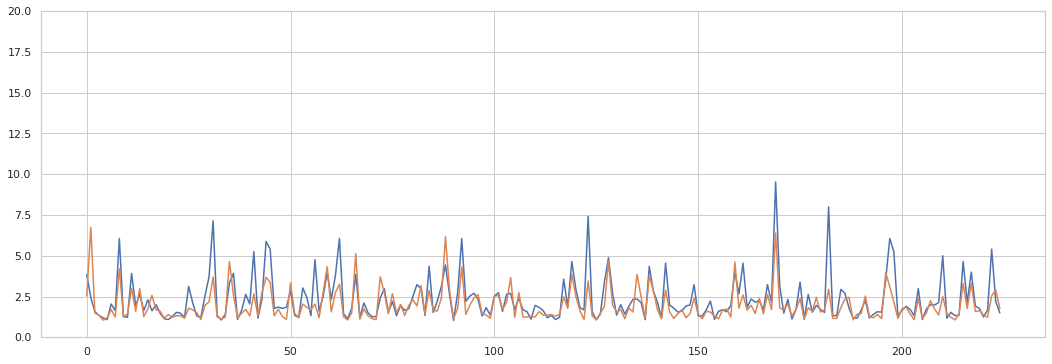

In [226]:
% matplotlib inline
plt.figure (figsize=(18,6))
plt.plot(dde['cote_1_basée_proba'])
plt.plot(dde['1'])
plt.ylim([0,20]);

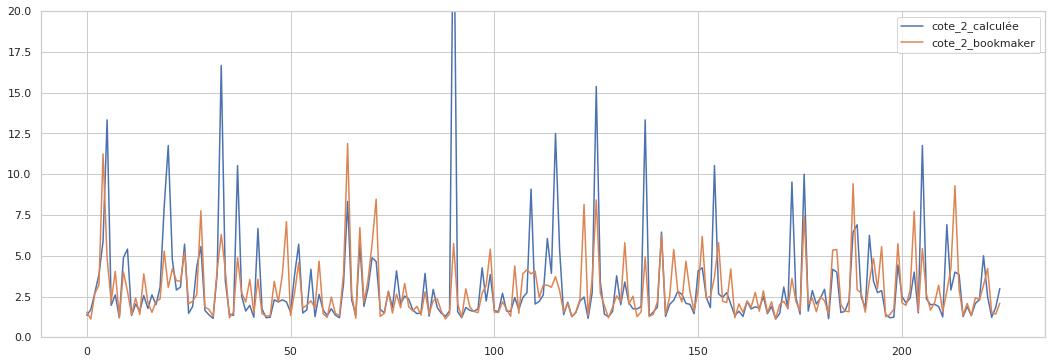

In [227]:
plt.figure (figsize=(18,6))
plt.plot(dde['cote_2_basée_proba'], label='cote_2_calculée')
plt.plot(dde['2'], label='cote_2_bookmaker')
plt.ylim([0,20])  # cette courbe montre qu'on doit avoir une invserion des cotes V1 et V2
plt.legend();

In [ ]:
# REPRISE DES EXPLOITATIONS DONNEES avec CatBoostClassifier

## Sorties PROBA CatBOOST

In [228]:
x_bis = catb.predict_proba((test_X), 
              ntree_start=0, 
              ntree_end=0, 
              thread_count=-1, 
              verbose=None)

In [229]:
dfffx=pd.DataFrame.from_dict(x_bis).rename(columns={0 : 'Prob_defaite_home', 1:'Prob_victoire_home' })

In [230]:
ddex=pd.concat([dfffx, test_X_Eval], axis=1)  #

In [231]:
ddex.head(5) #(-> structure)

,Prob_defaite_home,Prob_victoire_home,1,2
0,0.732007,0.267993,2.53,1.54
1,0.673886,0.326114,6.74,1.12
2,0.329237,0.670763,1.49,2.69
3,0.169400,0.830600,1.36,3.21
4,0.116060,0.883940,1.05,11.25


In [232]:
ddex['cote_1_basée_proba'] = np.round((1 / ddex['Prob_victoire_home']),2)
ddex['cote_2_basée_proba'] = np.round((1 / ddex['Prob_defaite_home']),2)
ddex['cote_1_naive_vict_home'] = 1 
ddex['cote_2_naive_vict_away'] = 0 
ddex.head(5) # basé modèle Catboost

,Prob_defaite_home,Prob_victoire_home,1,2,cote_1_basée_proba,cote_2_basée_proba,cote_1_naive_vict_home,cote_2_naive_vict_away
0,0.732007,0.267993,2.53,1.54,3.73,1.37,1,0
1,0.673886,0.326114,6.74,1.12,3.07,1.48,1,0
2,0.329237,0.670763,1.49,2.69,1.49,3.04,1,0
3,0.169400,0.830600,1.36,3.21,1.20,5.90,1,0
4,0.116060,0.883940,1.05,11.25,1.13,8.62,1,0


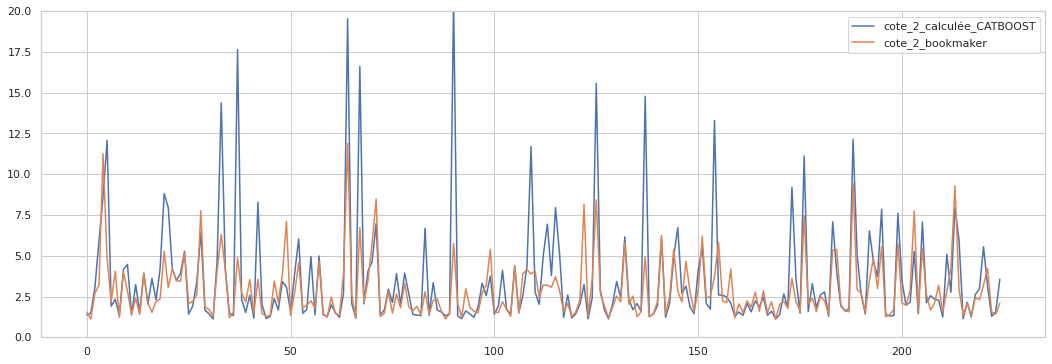

In [233]:
plt.figure (figsize=(18,6))
plt.plot(ddex['cote_2_basée_proba'], label='cote_2_calculée_CATBOOST')
plt.plot(ddex['2'], label='cote_2_bookmaker')
plt.ylim([0,20])  #
plt.legend();

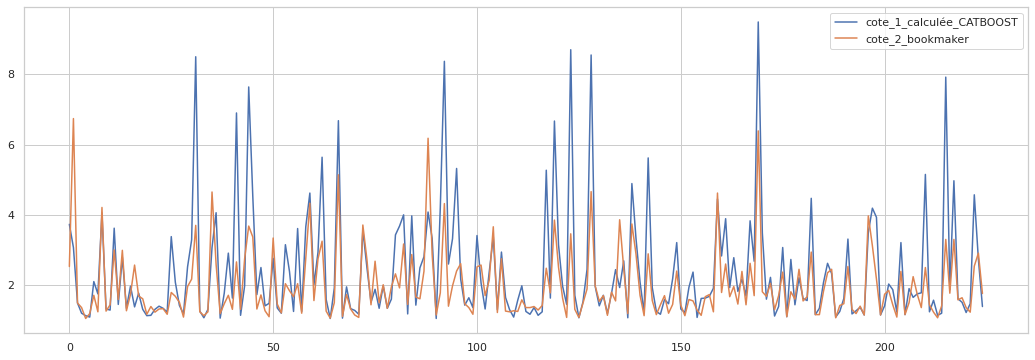

In [234]:
plt.figure (figsize=(18,6))
plt.plot(ddex['cote_1_basée_proba'], label='cote_1_calculée_CATBOOST')
plt.plot(ddex['1'], label='cote_2_bookmaker')
plt.legend();

In [235]:
# recherche de value_bet avec un coeef de sécurité 10% (intuitif)
vb1= ddex[ddex['1'] > ddex['cote_1_basée_proba']]
vb1.shape

(78, 8)

In [236]:
# recherche de value_bet
vb2= ddex[ddex['2']> ddex['cote_2_basée_proba']]
vb2.shape

(107, 8)

# suite -> new metrique

In [238]:
def bankroll(DATA):
  DATA["Bankroll"]=0.00
  if (DATA["HOME_TEAM_WINS_PRED"][0] == DATA["HOME_TEAM_WINS"][0]):
    DATA["Bankroll"][0]=10*float((DATA[str(DATA["HOME_TEAM_WINS"][0])][0]))-10
  else :
    DATA["Bankroll"][0]=-10.00
  for i in range(1,len(DATA)) :
    if (DATA["HOME_TEAM_WINS_PRED"][i] == DATA["HOME_TEAM_WINS"][i]):
      DATA["Bankroll"][i]=10*float((DATA[str(DATA["HOME_TEAM_WINS"][i])][i]))-10 + DATA["Bankroll"][i-1]
    else :
      DATA["Bankroll"][i]=DATA["Bankroll"][i-1]-10

def ROI(DATA):
  DATA["ROI"]=0.00
  for i in range(0,len(DATA)) :
      DATA["ROI"][i]=(DATA["Bankroll"][i]/((i+1)*10))*100

def ValueBet(DATA):
  DATA["ValueBet"]=0
  for i in range(0,len(DATA)) :
    if (DATA["Prob_victoire_home"][i]==max(DATA["Prob_victoire_home"][i],DATA["Prob_defaite_home"][i])):
      if ( ((DATA["Prob_victoire_home"][i]) - 1/(DATA["1"][i])) > 0 ) :
        DATA["ValueBet"][i]=1
      else:
        DATA["ValueBet"][i]=0
    else:
      if ( ((DATA["Prob_defaite_home"][i]) - 1/(DATA["2"][i])) > 0 ) :
        DATA["ValueBet"][i]=1
      else:
        DATA["ValueBet"][i]=0

def sucessRate(DATA):
  DATA["SucessRate"]=0.0
  for i in range(0,len(DATA)) :
    if(DATA["HOME_TEAM_WINS_PRED"][i] == DATA["HOME_TEAM_WINS"][i]):
      DATA["SucessRate"][i]=1
    else :
      DATA["SucessRate"][i]=0
      
def ACCU(DATA):
  DATA["Accuracy"]=0.0
  for i in range(0,len(DATA)) :
    if(len(DATA["SucessRate"][0:i+1].value_counts(normalize=True))>1):
      DATA["Accuracy"][i]=DATA["SucessRate"][0:i+1].value_counts(normalize=True)[1]

In [239]:
## Recuperation des dates pour assurer la chronologie de la bankroll
Date_info=test_X[["GAME_ID","SEASON","STANDINGSDATE","1","2"]]
Date_info.head()
Rslt=pd.DataFrame(test_y)
#GAME_ID 	SEASON 	STANDINGSDATE 	1 	2 	HOME_TEAM_WINS
Date_rslt=pd.merge(Date_info, Rslt, left_index=True, right_index=True)
Date_rslt.head()
#DATAFRAME DE TRAVAIL#
BK=pd.merge(Date_rslt,ddex,left_on=["1","2"],right_on=["1","2"])
BK=BK.sort_values(by="STANDINGSDATE").reset_index(drop=True)
BK.head()
# Legère modification de la var HOME_TEAM_WINS au lieu de 0 pour defaite et 1 pour WIN , elle représente le résultat du match : 1 = Victoire a domicile, 2= victoire à l'extérieur 
# Plus simple pour coller au côtes
BK["HOME_TEAM_WINS_PRED"]=2
BK["HOME_TEAM_WINS_PRED"][BK["Prob_victoire_home"]>0.5]=1
BK["HOME_TEAM_WINS"][BK["HOME_TEAM_WINS"]==0]=2
BK=BK.drop_duplicates(subset="GAME_ID").reset_index(drop=True)

In [240]:
ValueBet(BK)
bankroll(BK)
ROI(BK)
sucessRate(BK)
ACCU(BK)


In [241]:
print("Accu =",BK["Accuracy"][len(BK)-1], "BK =",BK["Bankroll"][len(BK)-1], "ROI =",BK["ROI"][len(BK)-1])

Accu = 0.6577777777777778 BK = -101.39999999999986 ROI = -4.506666666666661


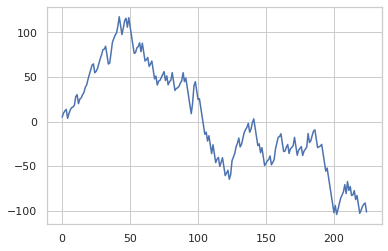

In [242]:
BK["Bankroll"].plot()

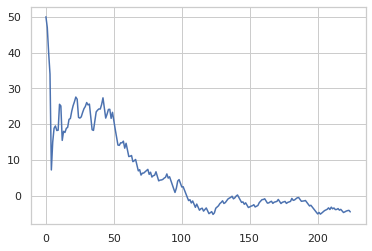

In [243]:
BK["ROI"].plot()

In [244]:
ValueBet(BK)
BK=BK[BK["ValueBet"]==1].reset_index(drop=True)
bankroll(BK)
ROI(BK)
sucessRate(BK)
ACCU(BK)


In [245]:
print("Accu =",BK["Accuracy"][len(BK)-1], "BK =",BK["Bankroll"][len(BK)-1], "ROI =",BK["ROI"][len(BK)-1])

Accu = 0.6456692913385826 BK = 12.800000000000011 ROI = 1.0078740157480324


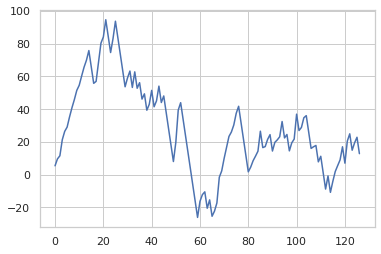

In [246]:
BK["Bankroll"].plot()

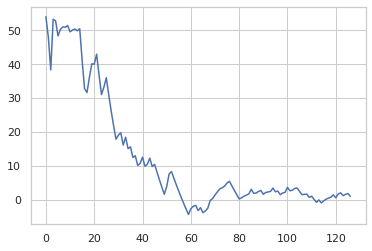

In [247]:
BK["ROI"].plot()